In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

from stog.utils.params import Params
from stog.data.dataset_builder import dataset_from_params, iterator_from_params
from stog.data.vocabulary import Vocabulary
from stog.training.trainer import Trainer
from stog.data.dataset import Batch
from model.text_to_amr import TextToAMR

from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError

[2020-02-20 09:45:33,971 INFO] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [3]:
params = Params.from_file("../model/model_params.yaml")

/home/adylanrff/Documents/Kuliah/TA/amr_parser/stog/utils/params.py:104: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dict_merge.dict_merge(params_dict, yaml.load(f))


In [4]:
data_params = params['data']
dataset = dataset_from_params(data_params)

[2020-02-20 09:45:35,340 INFO] Building train datasets ...
[2020-02-20 09:45:35,342 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn't find any file associated to this path or url.
0it [00:00, ?it/s][2020-02-20 09:45:35,344 INFO] Reading instances from lines in file at: ../data/raw/amr.txt.features
[2020-02-20 09:45:35,398 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 733.96it/s]
[2020-02-20 09:45:35,399 INFO] Building dev datasets ...
[2020-02-20 09:45:35,399 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-

In [5]:
train_data = dataset['train']
dev_data = dataset.get('dev')
test_data = dataset.get('test')

In [6]:
vocab_params = params.get('vocab', {})
vocab = Vocabulary.from_instances(instances=train_data, **vocab_params)
vocab.save_to_files("../data/processed/serialization")

dataset = Batch(train_data)
dataset.index_instances(vocab)
dataset.index_instances(vocab)

# print(dataset.as_tensor_dict()['src_tokens']['encoder_tokens'][1].numpy())
# print(dataset.as_tensor_dict()['tgt_tokens']['decoder_tokens'][1].numpy())
# print(dataset.get_padding_lengths())
# print(dataset.as_tensor_dict())

for key in dataset.as_tensor_dict():
    print(key)
    content = dataset.as_tensor_dict()[key]
    if isinstance(content, dict):
        for inner_key in content:
            print("  ", inner_key)

train_iterator, dev_iterater, test_iterater = iterator_from_params(vocab, data_params['iterator'])

train_dataset = Batch(train_data)
train_dataset.index_instances(vocab)

test_dataset = Batch(test_data)
test_dataset.index_instances(vocab)

train_dataset = train_dataset.as_tensor_dict()
test_dataset = test_dataset.as_tensor_dict()

[2020-02-20 09:45:35,528 INFO] Fitting token dictionary from dataset.
100%|██████████| 40/40 [00:00<00:00, 2388.22it/s]
[2020-02-20 09:45:35,549 WARNING] vocabulary serialization directory ../data/processed/serialization is not empty


src_tokens
   encoder_tokens
   encoder_characters
src_must_copy_tags
tgt_tokens
   decoder_tokens
   decoder_characters
src_pos_tags
tgt_pos_tags
tgt_copy_indices
tgt_copy_mask
tgt_copy_map
src_copy_indices
src_copy_map
head_tags
head_indices


In [7]:
print(vocab)

Vocabulary with namespaces:
 	Non Padded Namespaces: {'coref_tags', 'must_copy_tags'}
 	Namespace: encoder_token_ids, Size: 334 
 	Namespace: encoder_token_characters, Size: 39 
 	Namespace: decoder_token_ids, Size: 283 
 	Namespace: decoder_token_characters, Size: 65 
 	Namespace: pos_tags, Size: 16 
 	Namespace: head_tags, Size: 35 



###### Test Model

In [8]:
text_to_amr = TextToAMR(vocab)
model = text_to_amr.model
model.compile(optimizer='rmsprop', loss="mean_squared_error")

[2020-02-20 09:45:35,943 WARNING] From /home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[2020-02-20 09:45:35,955 WARNING] From /home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[2020-02-20 09:45:36,008 WARNING] From /home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from ten

source_attention (?, 400)
coref_attention (?, 400)


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_encoder_input (InputLayer [(None, 25)]         0                                            
__________________________________________________________________________________________________
pos_encoder_input (InputLayer)  [(None, 25)]         0                                            
__________________________________________________________________________________________________
glove_embedding (GloveEmbedding (None, 25, 100)      33400       token_encoder_input[0][0]        
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 100)      1600        pos_encoder_input[0][0]          
______________________________________________________________________________________________

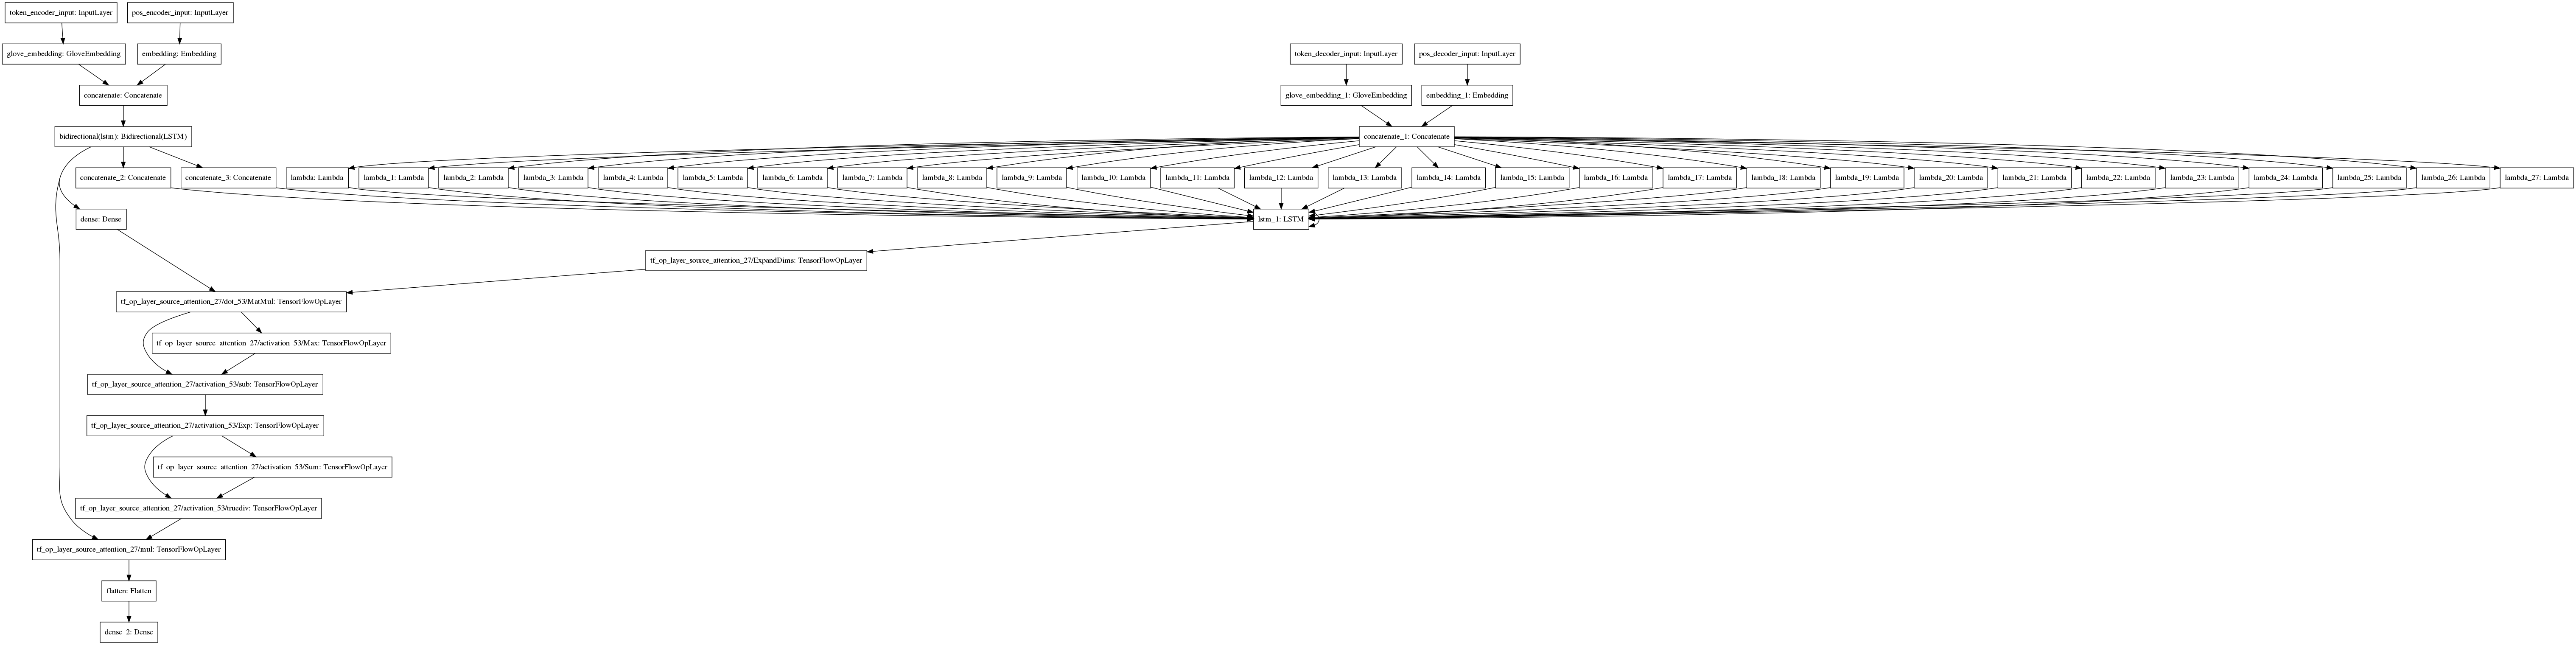

In [10]:
plot_model(model)

In [11]:
encoder_input, decoder_input = text_to_amr.prepare_input(train_dataset)

In [ ]:

token_encoder_input = encoder_input.get('token').numpy()
pos_encoder_input = encoder_input.get('pos_tag').numpy()
token_decoder_input = decoder_input.get('token').numpy()
pos_decoder_input = decoder_input.get('pos_tag').numpy()

model_input = [token_encoder_input, pos_encoder_input, token_decoder_input, pos_decoder_input]
model.fit(model_input, [1 for _ in range(len(model_input[0]))], epochs=10)

[2020-02-20 09:45:57,824 WARNING] From /home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40 samples
Epoch 1/10
